# Model Training & Evaluation

Here we finally train and test different models to find the best ones.

We test the following models:
- Logistic Regression.
- Naive Bayes.
- Decision Tree.
- Random Forest.
- XGBoost.
- LightGBM.

Also, for each of the models:
1. We first apply the **K-Fold Cross Validation** (with k=5) to find the best model family.
2. We also train a model again for each of them, in order to compare different metrics for each of them when the model is trained on the whole training dataset.

The metrics we use are:
- Accuracy.
- Cross-Validation Accuracy
- Cross-Validation Standard Deviation.
- ROC-AUC.

# Imports

In [25]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning models and tools
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Data preprocessing and utilities
from sklearn.model_selection import cross_val_score

# Metrics and evaluation
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc,
)

# Loading preprocessed datasets

In [26]:
# Load datasets
X_train = pd.read_csv("../database/preprocessed_dataset/X_train.csv")
y_train = pd.read_csv("../database/preprocessed_dataset/y_train.csv")
X_test = pd.read_csv("../database/preprocessed_dataset/X_test.csv")
y_test = pd.read_csv("../database/preprocessed_dataset/y_test.csv")

# Models

In [27]:
# List of models to train
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    "XGBoost": XGBClassifier(eval_metric='mlogloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
}

In [28]:
# Ensure y_train and y_test are 1D
y_train = y_train.values.ravel() if isinstance(y_train, pd.DataFrame) else y_train.ravel()
y_test = y_test.values.ravel() if isinstance(y_test, pd.DataFrame) else y_test.ravel()

In [29]:
# Train and evaluate models
results = {}

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")

    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{model_name} Cross-Validation Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

    # Train the model on the whole training dataset this time
    model.fit(X_train, y_train)

    # Test set predictions
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    confusion = confusion_matrix(y_test, y_pred)
    # Extract probabilities for the positive class (class 1)
    y_pred_prob_positive = y_pred_prob[:, 1]
    # Compute the ROC AUC score
    roc_auc = roc_auc_score(y_test, y_pred_prob_positive)

    # Store results
    results[model_name] = {
        "Accuracy": accuracy,
        "Cross-Validation Accuracy": cv_scores.mean(),
        "Cross-Validation Std Dev": cv_scores.std(),
        "Classification Report": class_report,
        "Confusion Matrix": confusion,
        "ROC AUC": roc_auc,
    }

    # Print metrics
    print(f"\nModel: {model_name}")
    print(f"Test Set Accuracy: {accuracy:.4f}")
    if roc_auc is not None:
        print(f"ROC AUC: {roc_auc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    print("Confusion Matrix:")
    print(confusion)
    print("\n" + "=" * 60 + "\n")


Training Logistic Regression...
Logistic Regression Cross-Validation Accuracy: 0.9824 (+/- 0.0013)

Model: Logistic Regression
Test Set Accuracy: 0.9810
ROC AUC: 0.9976
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     13417
           1       0.38      0.99      0.55       158

    accuracy                           0.98     13575
   macro avg       0.69      0.98      0.77     13575
weighted avg       0.99      0.98      0.99     13575

Confusion Matrix:
[[13161   256]
 [    2   156]]



Training Naive Bayes...
Naive Bayes Cross-Validation Accuracy: 0.9843 (+/- 0.0043)

Model: Naive Bayes
Test Set Accuracy: 0.9883
ROC AUC: 0.9913
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     13417
           1       0.50      0.82      0.62       158

    accuracy                           0.99     13575
   macro avg       0.75      0.90      0.8

## Summary of results

In [30]:
# Display summary results
results_df = pd.DataFrame({
    model: {
        "Test Accuracy": metrics["Accuracy"],
        "Cross-Val Accuracy": metrics["Cross-Validation Accuracy"],
        "ROC AUC": metrics["ROC AUC"],
    }
    for model, metrics in results.items()
}).T

print("Summary of Results:")
print(results_df)

Summary of Results:
                     Test Accuracy  Cross-Val Accuracy   ROC AUC
Logistic Regression       0.980994            0.982431  0.997566
Naive Bayes               0.988287            0.984298  0.991255
Decision Tree             0.995138            0.993666  0.900594
Random Forest             0.993886            0.996200  0.998415
XGBoost                   0.996759            0.997016  0.999316
LightGBM                  0.997127            0.997616  0.999456


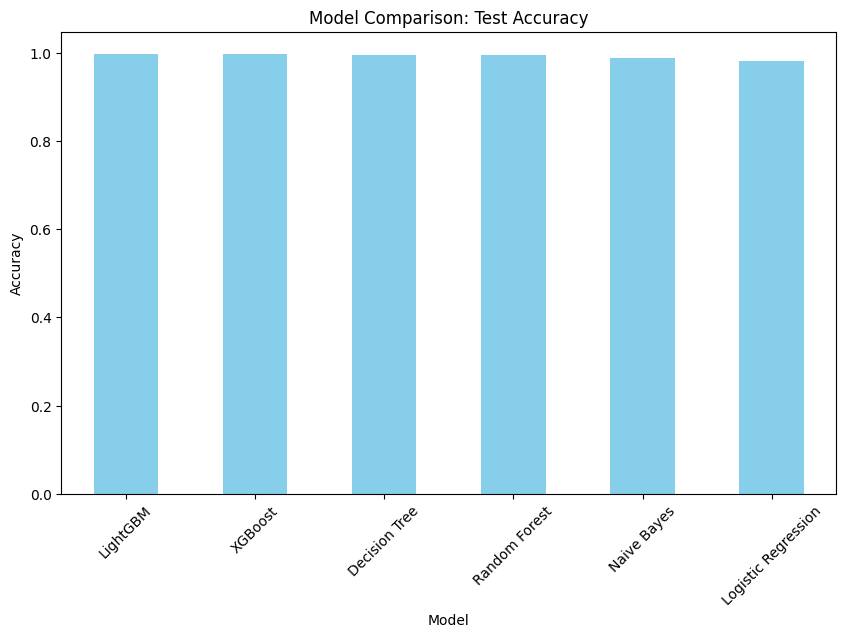

In [31]:
# Plot Test Accuracy for Comparison
plt.figure(figsize=(10, 6))
results_df["Test Accuracy"].sort_values(ascending=False).plot(kind="bar", color="skyblue")
plt.title("Model Comparison: Test Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.show()

# Analysis of Results

The LightGBM model provides key insights for predicting the eligibility of a customer.

## Train best model

In [32]:
# Train the final Random Forest model
final_model = LGBMClassifier(random_state=42)
final_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = final_model.predict(X_test)
y_pred_prob = final_model.predict_proba(X_test)

[LightGBM] [Info] Number of positive: 6330, number of negative: 53663
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2887
[LightGBM] [Info] Number of data points in the train set: 59993, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.105512 -> initscore=-2.137424
[LightGBM] [Info] Start training from score -2.137424


## Compute metrics of performance

In [33]:
# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
confusion = confusion_matrix(y_test, y_pred)
# Extract probabilities for the positive class (class 1)
y_pred_prob_positive = y_pred_prob[:, 1]
# Compute the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob_positive)

In [34]:
# Print metrics
print(f"Final Model: LightGBM")
print(f"Test Set Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))
print("Confusion Matrix:")
print(confusion)

Final Model: LightGBM
Test Set Accuracy: 0.9971
ROC AUC: 0.9995
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13417
           1       0.84      0.94      0.88       158

    accuracy                           1.00     13575
   macro avg       0.92      0.97      0.94     13575
weighted avg       1.00      1.00      1.00     13575

Confusion Matrix:
[[13388    29]
 [   10   148]]


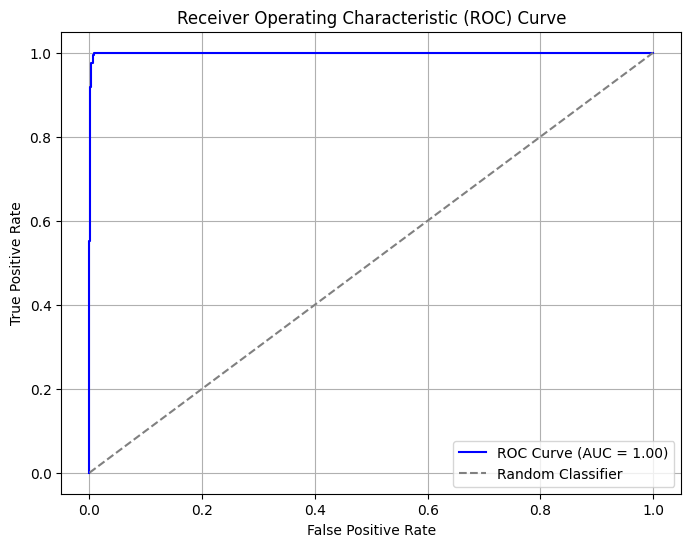

In [35]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_positive)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Random Classifier")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()